In [11]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [12]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']
columns =  eye_data_names + channels



data, header = pyxdf.load_xdf('data/zero-butter/1/dejittered-iir-3order-0.75to5-eeg-and-dejittered-eyetracking.xdf')


In [13]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

def plot_eeg_single(df,df_ts, column):
    axis = plt.subplot()
    axis.plot(df_ts['time'], df[column])
    axis.set_title(column)
    plt.show()

def plot_eeg(stream):
    df = pd.DataFrame(stream['time_series'])
    df.columns = columns
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.plot(stream['time_stamps'], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()



def get_peaks(df, start, end, column, rang=50, scale=1, order=5, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y[rang-20:rang+40])
    peaks = [peak + rang-20 for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0
    peak = peaks[np.argmax([y[i] for i in peaks])]+ start - rang

    return  peak if end + rang > peak > start - rang else start



In [14]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()


def plot_eeg_blink_all(stream, start, end,rang = 50):
    df = pd.DataFrame(stream['time_series'])
    df.columns = columns
    df = df[start - rang:end + rang]
    index = 0
    for i in range(32):
        color = 'blue'
        index += 1
        if channels[i] in removed_channels:
            color = 'red'

        axis = plt.subplot()
        axis.axvline(stream['time_stamps'][start], color='red')  # y = 0
        axis.axvline(stream['time_stamps'][end], color='red')
        axis.plot(stream['time_stamps'][start-rang:end+rang], df[channels[i]], color=color)
        axis.set_title(channels[i])
        plt.show()

In [15]:
stream = None
df_stream = None
df_stream_ts = None
for s in data:
    stream = s
    y = stream['time_series']
    df_stream = pd.DataFrame(y)
    df_stream_ts = pd.DataFrame(stream['time_stamps'])
    df_stream_ts.columns = ['time']
    df_stream.columns = columns

def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink

left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [16]:

avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

[420, 651, 905, 1166, 1416, 1662, 1920, 2171, 2425]
[447, 682, 937, 1194, 1444, 1691, 1954, 2203, 2460]


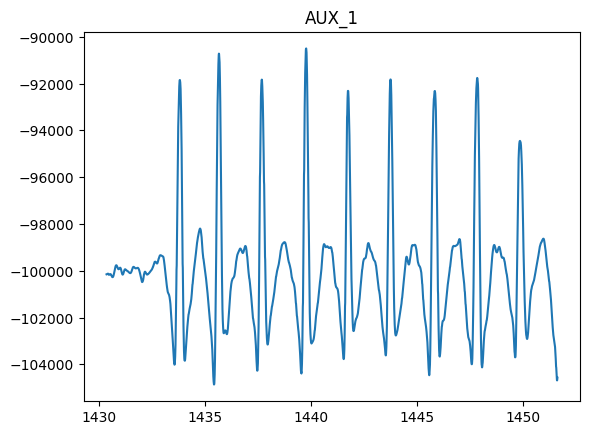

0


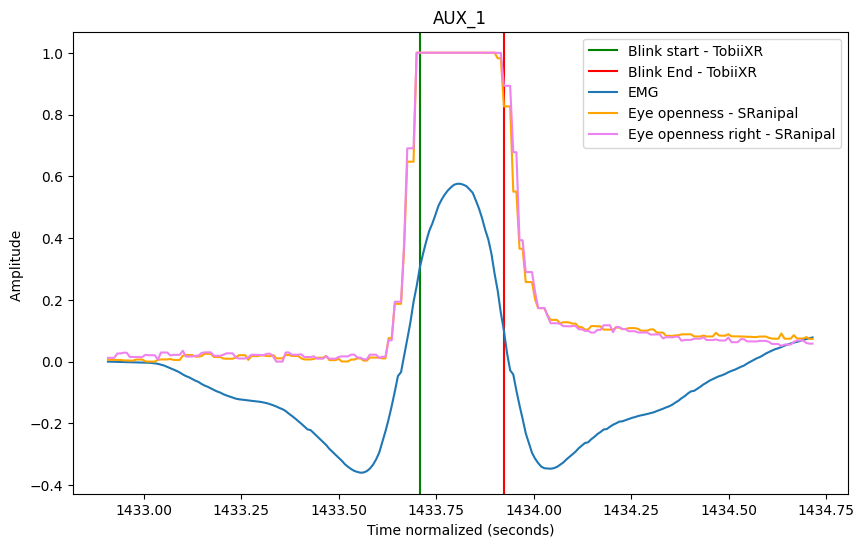

1


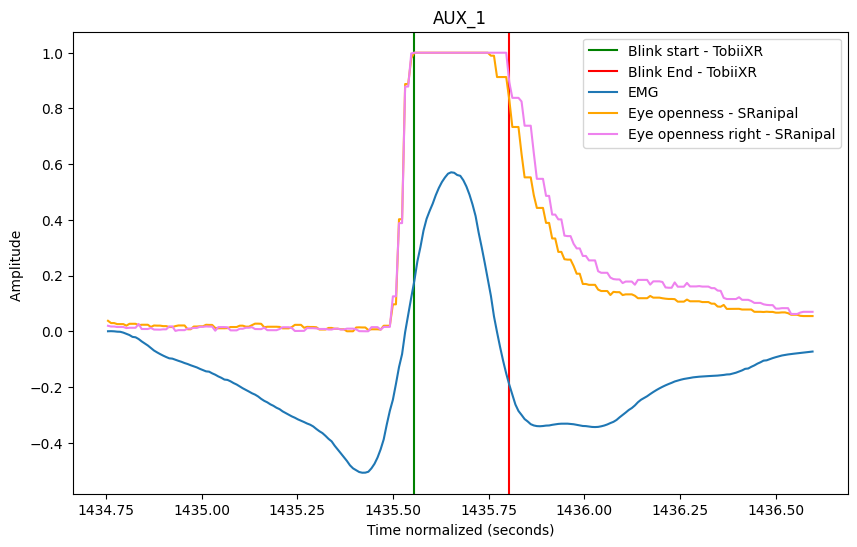

2


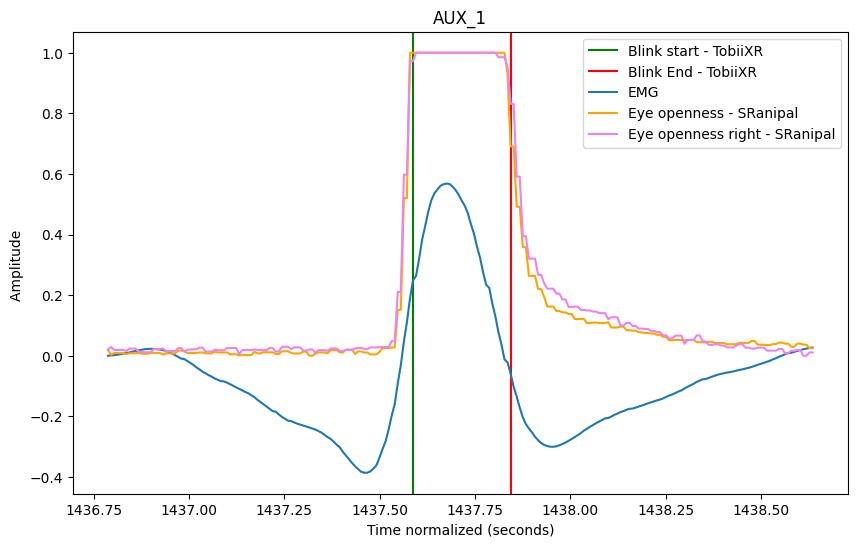

3


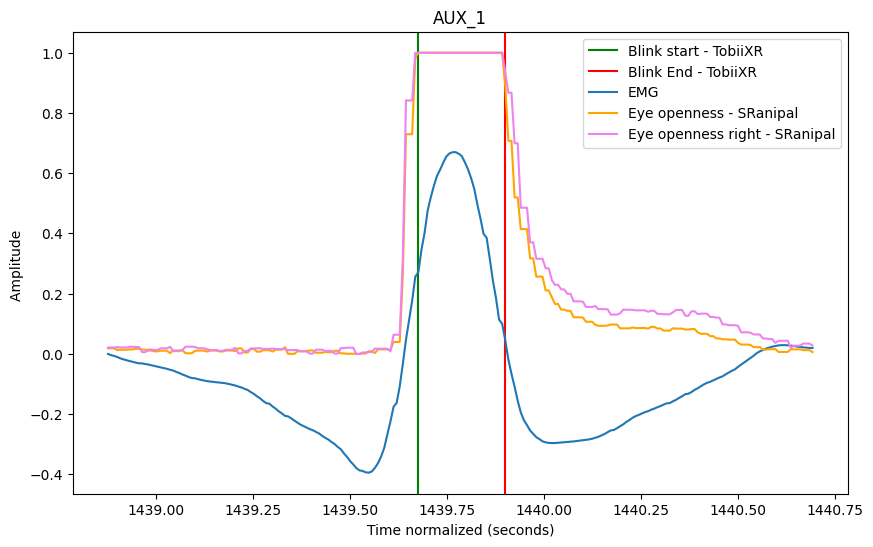

4


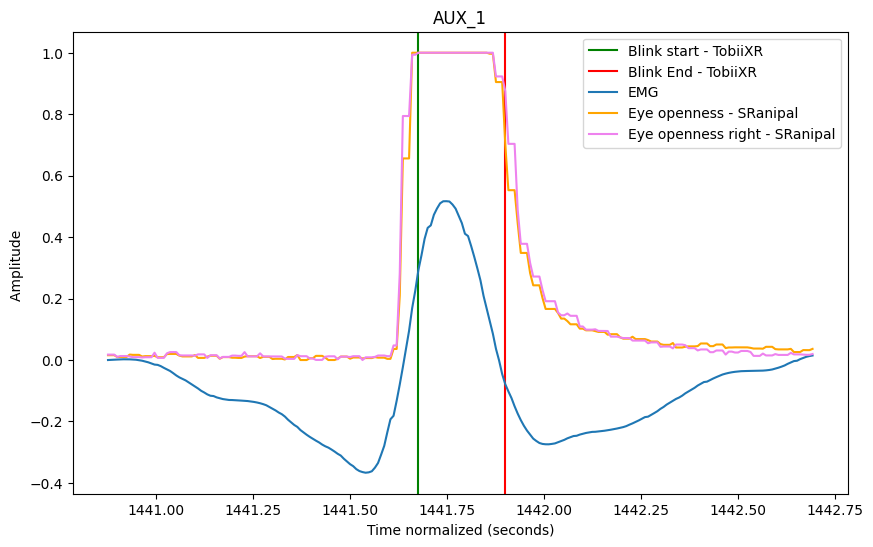

5


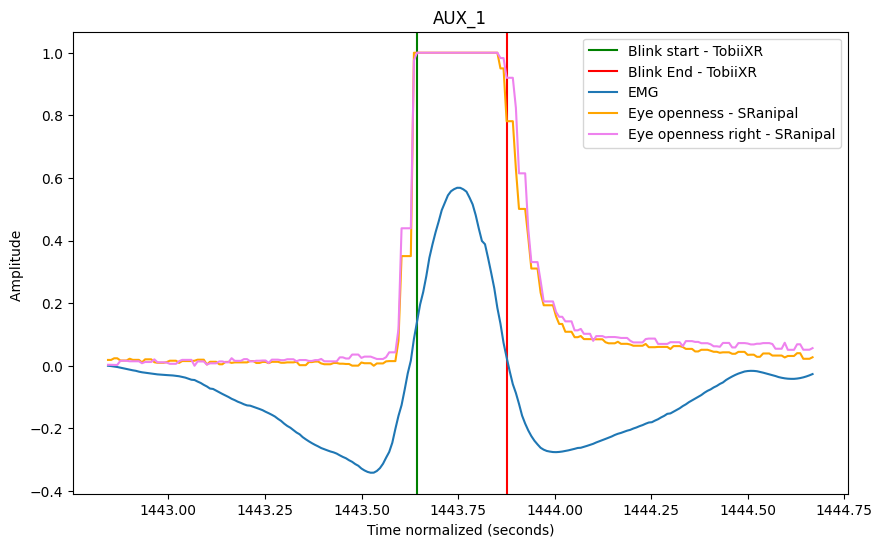

6


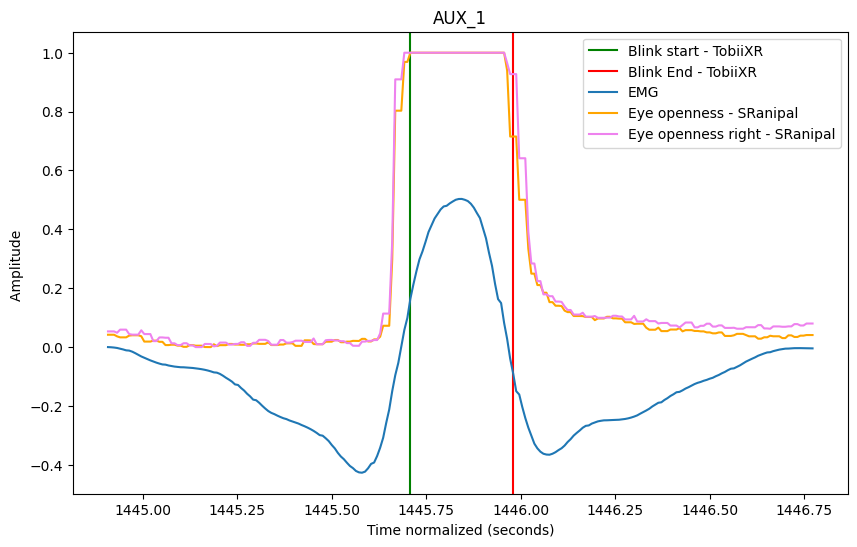

7


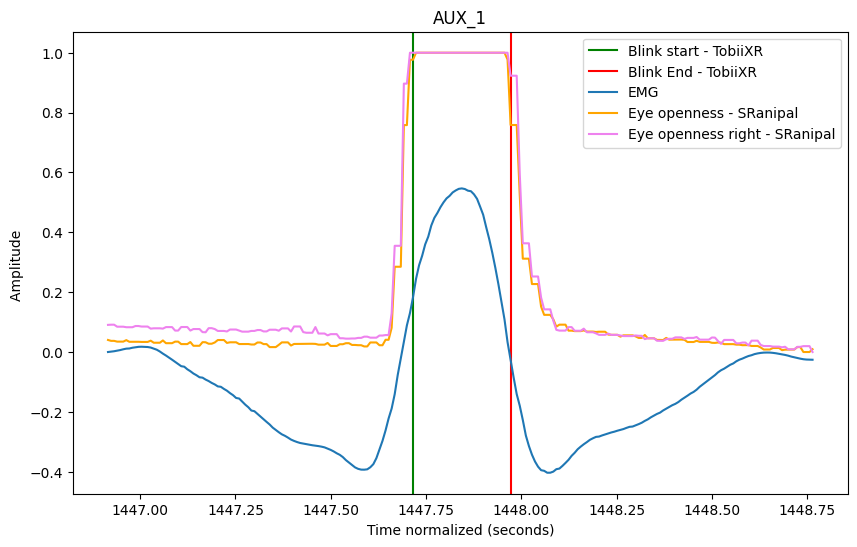

8


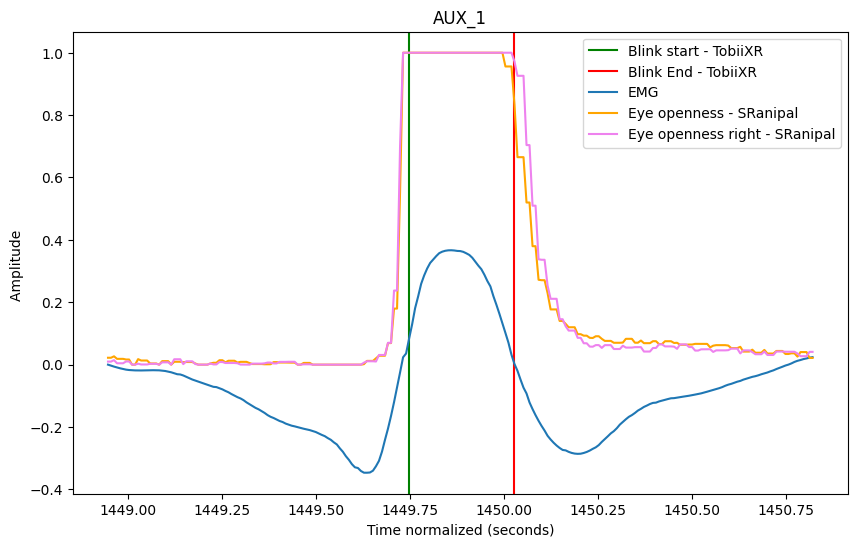

In [17]:
start, end = get_time_stamps(both_blink)

flip = True
chosen_channel = 'AUX_1'
print(start)
print(end)
df_stream['AUX_1'] = df_stream['AUX_1'] + 100000
plot_eeg_single(df_stream*(-1), df_stream_ts, chosen_channel)
for i in range(len(start)):
    print(i)
    plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 100, scale=8, flip=flip)
#plot_eeg_blink_all(stream, start[1], end[1])
#plot_eeg(stream)

In [18]:
from scipy.signal import butter, lfilter
# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 1
highcut = 28

def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]

    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(round(y[i])) + ", " + str(i+ start - rang))
    axis.set_title(column)
    plt.legend()
    plt.show()

    return peaks[np.argmax([y[i] for i in peaks])]+ start - rang ## Get only highest blink onset

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plot_eeg_blink_single_norm_butter(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = butter_bandpass_filter((df_norm + plus) *(-1 if flip else 1) *scale, lowcut, highcut, fs, order=order)
    peaks, _ = signal.find_peaks(y[rang-10:rang+100])
    peaks = [peak + rang-10 for peak in peaks]

    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i+ start - rang))
    axis.set_title(column)
    plt.legend()
    plt.show()

    return peaks[np.argmax([y[i] for i in peaks])]+ start - rang ## Get only highest blink onset

def get_peaks(df, start, end, column, rang=50, scale=1, order=5, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = butter_bandpass_filter((df_norm + plus) *(-1 if flip else 1) *scale, lowcut, highcut, fs, order=order)
    peaks, _ = signal.find_peaks(y, height=1)
    return peaks[np.argmax([y[i] for i in peaks])]+ start - rang ## Get only highest blink onset


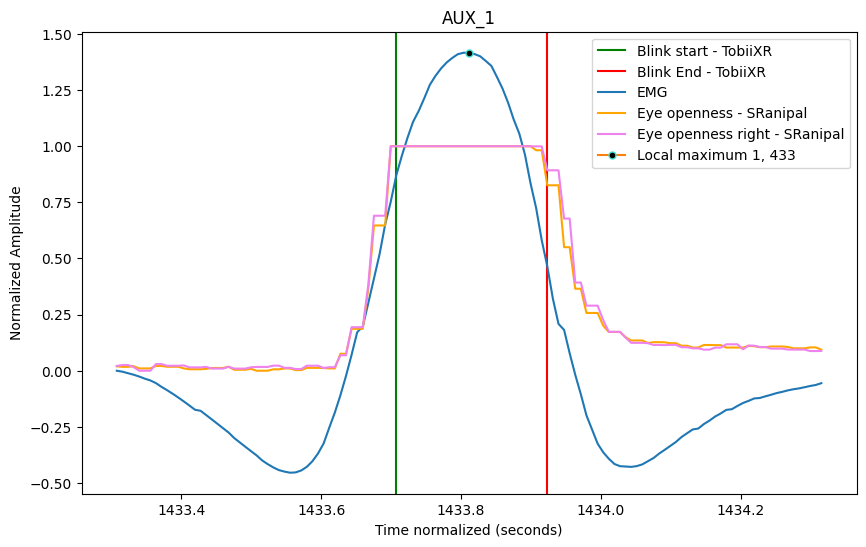

[433]


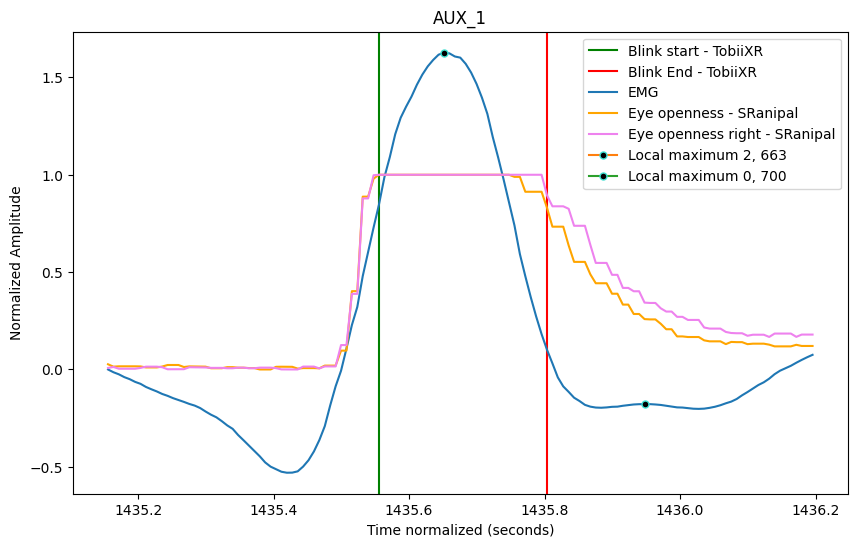

[433, 663]


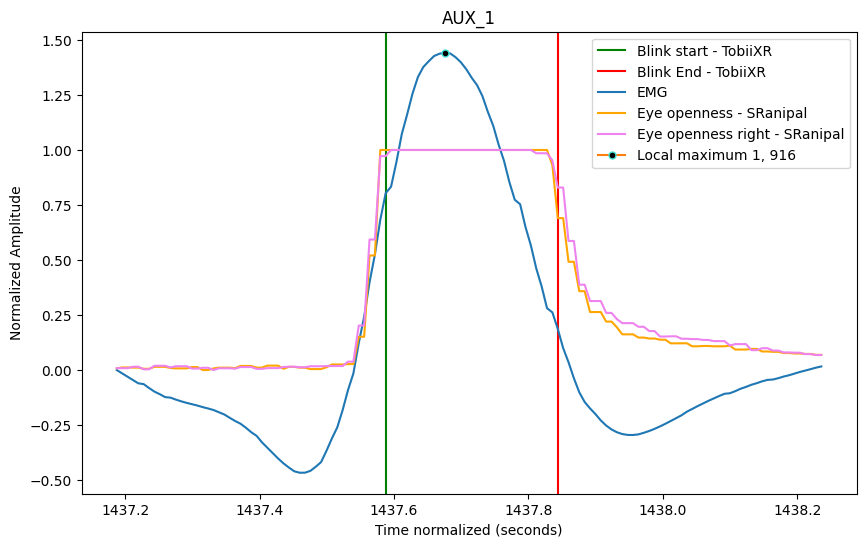

[433, 663, 916]


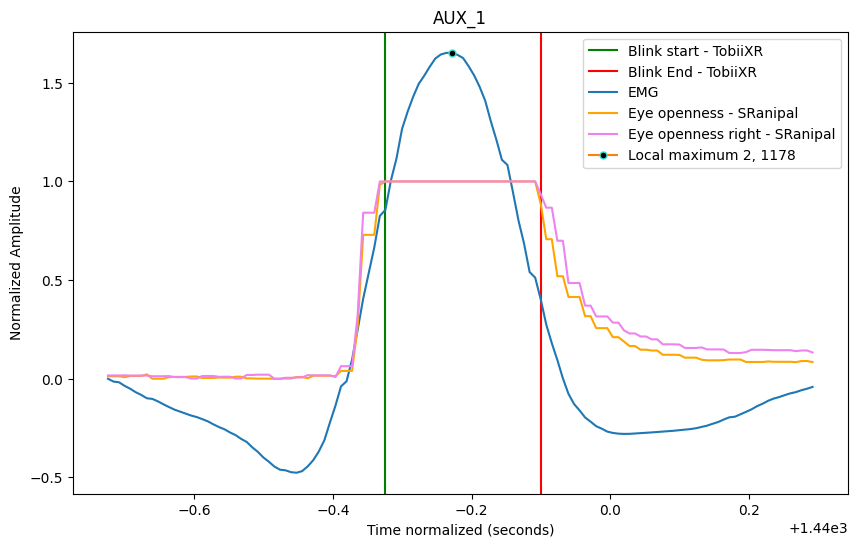

[433, 663, 916, 1178]


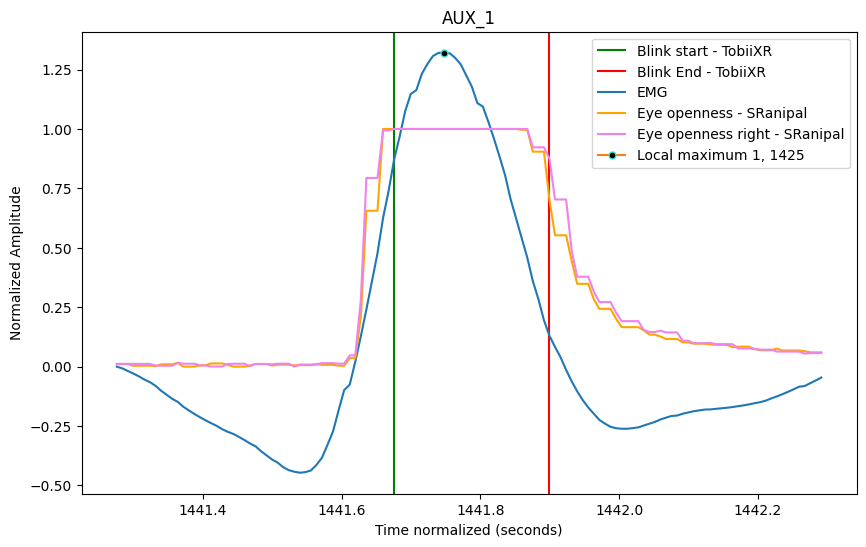

[433, 663, 916, 1178, 1425]


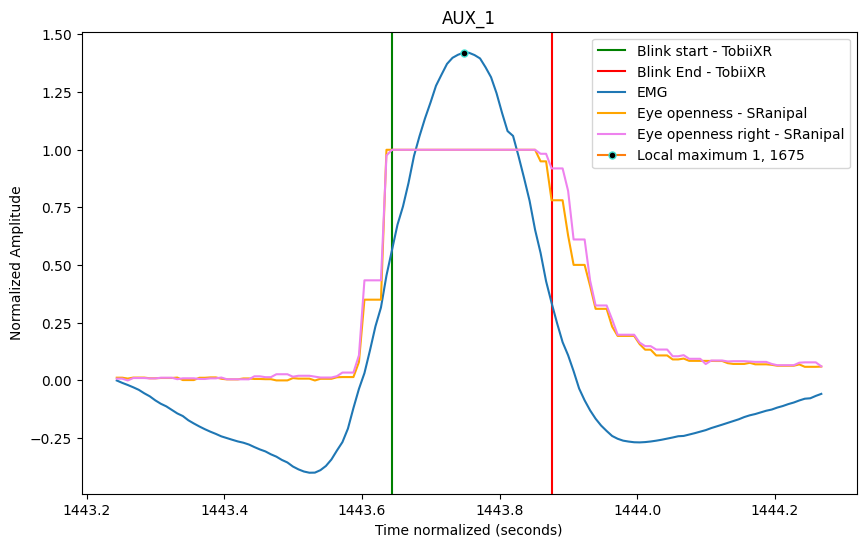

[433, 663, 916, 1178, 1425, 1675]


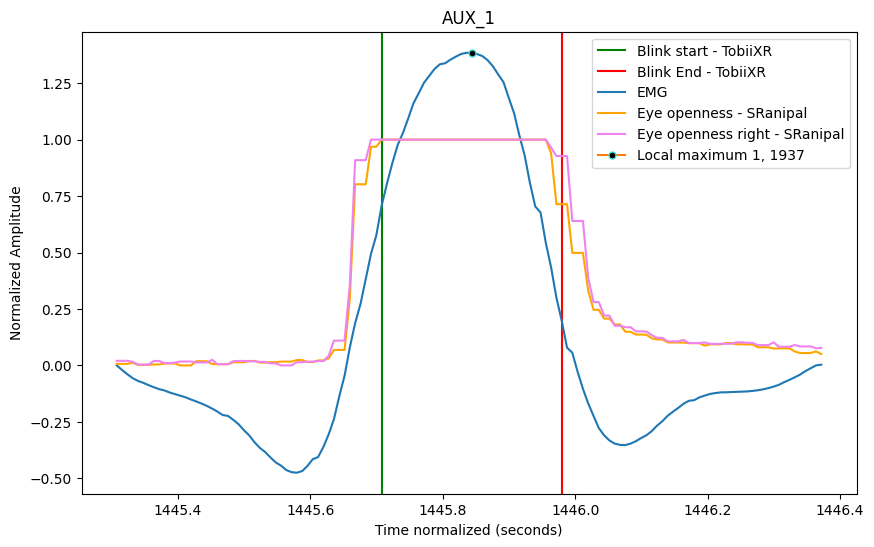

[433, 663, 916, 1178, 1425, 1675, 1937]


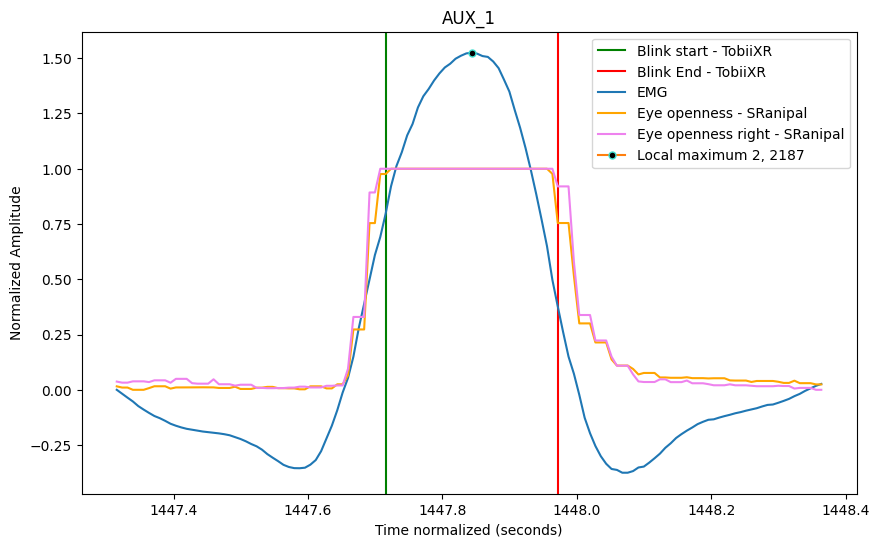

[433, 663, 916, 1178, 1425, 1675, 1937, 2187]


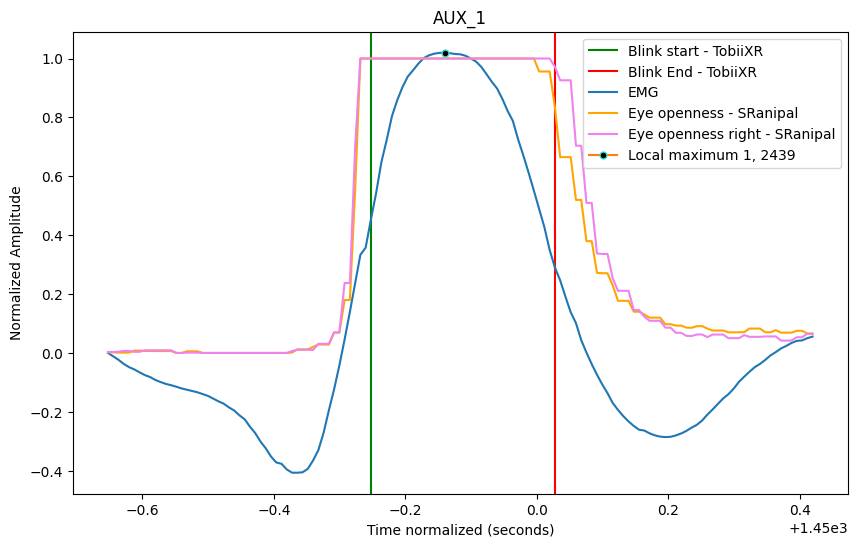

[433, 663, 916, 1178, 1425, 1675, 1937, 2187, 2439]


In [19]:
peaks = []
for i in range(len(start)):
    peaks.append(plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 50, scale=16, flip=flip, order=4))
    print(peaks)

[-13, -12, -11, -12, -9, -13, -17, -16, -14]
-13.0


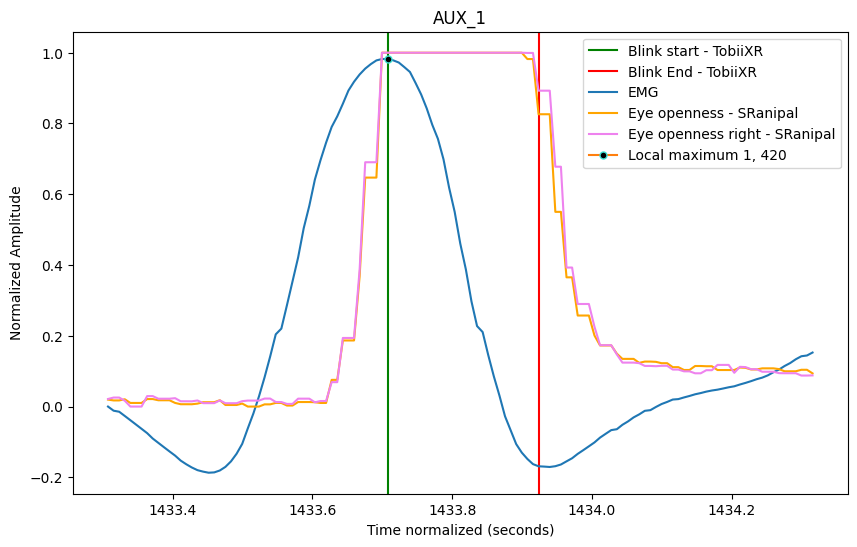

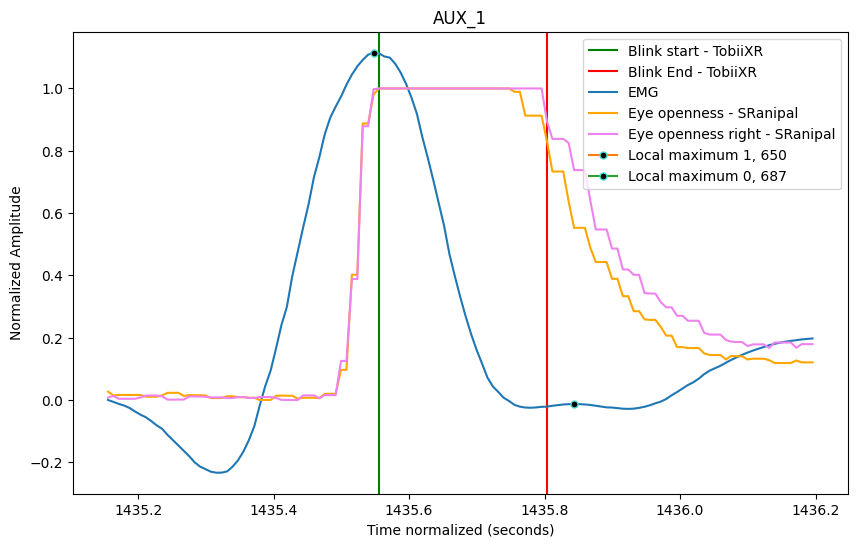

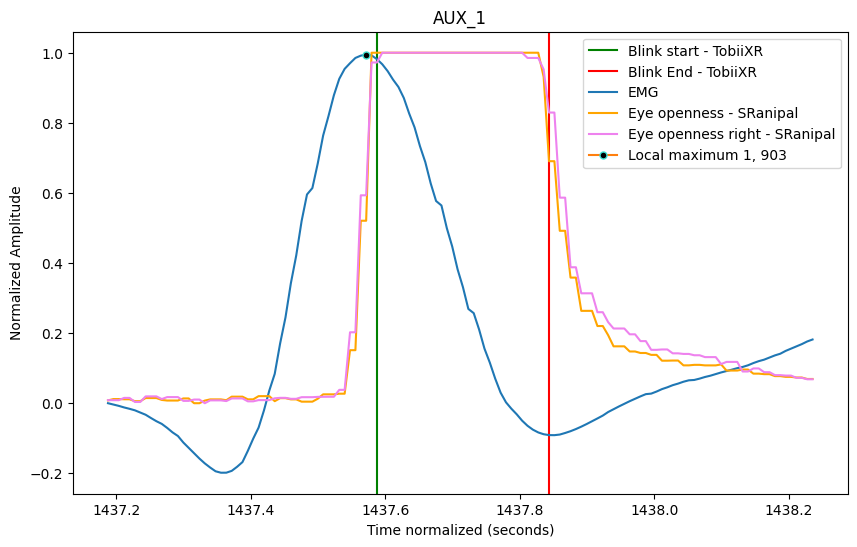

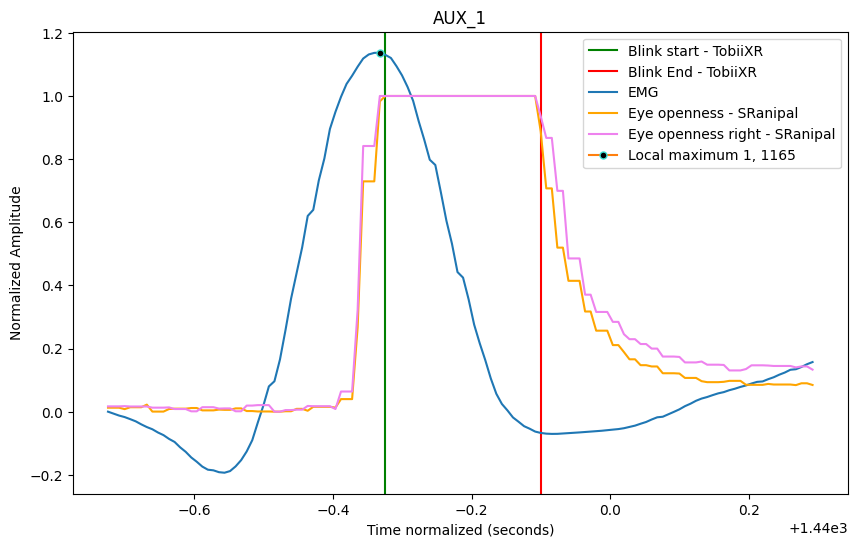

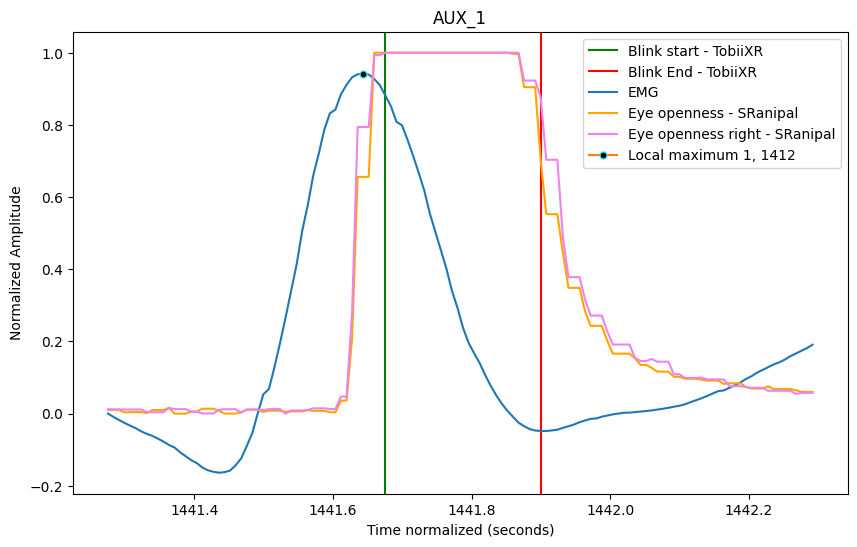

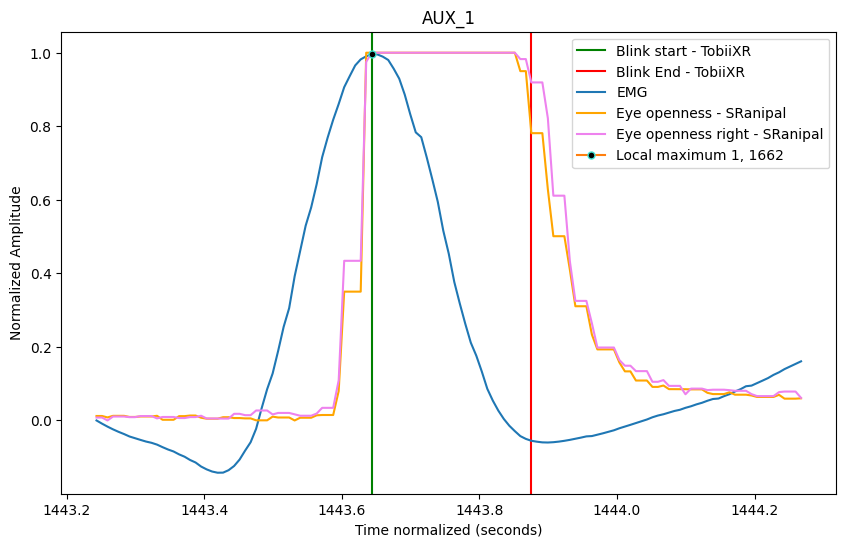

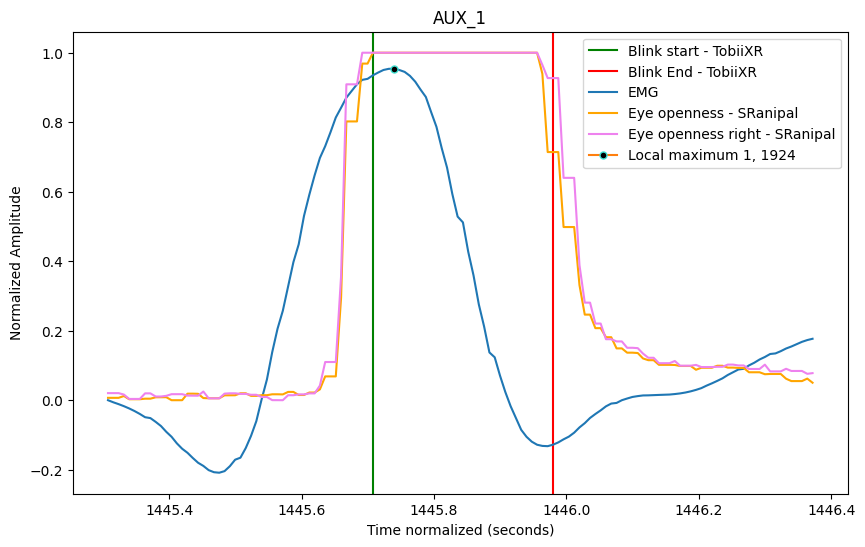

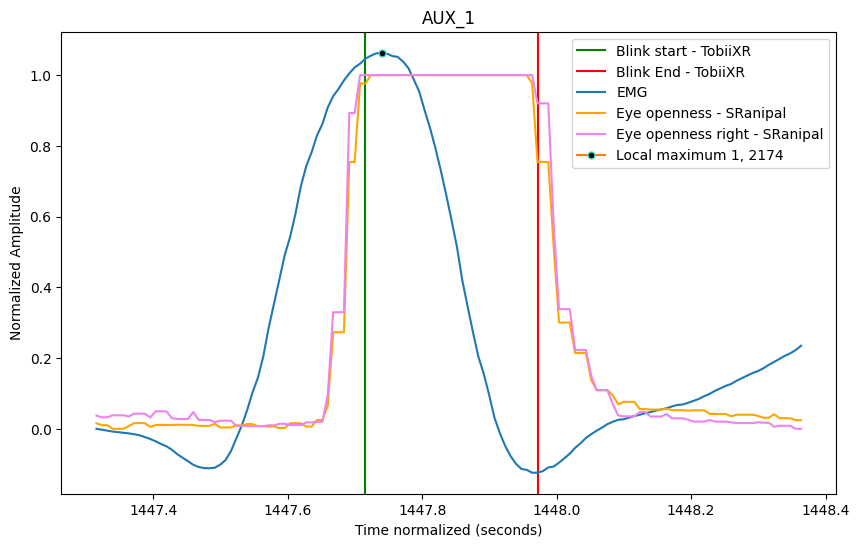

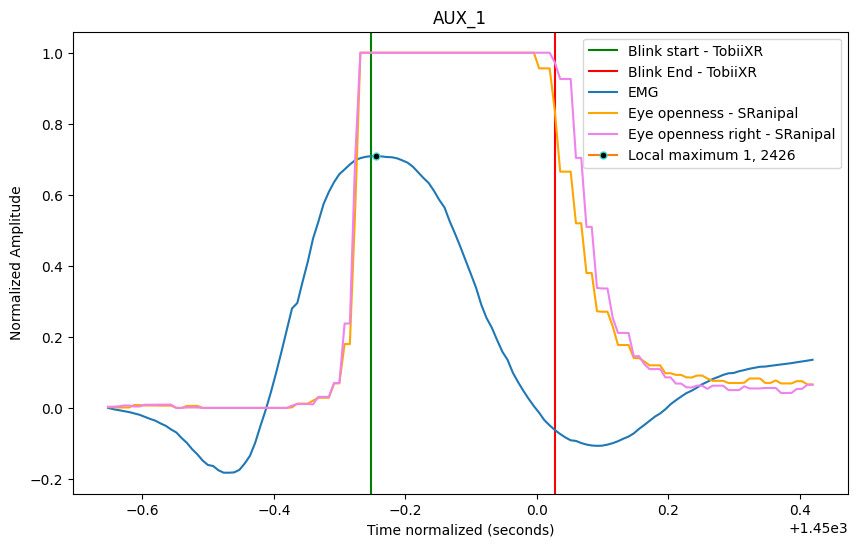

In [20]:
def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    print(differences_start)
    return sum(differences_start) / len(start)

shift = find_shift(start, peaks)
print(shift)
df_stream['AUX_1'] = df_stream['AUX_1'].shift(round((-13)))
for i in range(len(start)):
    #plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 50, scale=5, flip=True)
    plot_eeg_blink_single_norm(df_stream,df_stream_ts, start[i], end[i], chosen_channel, 50, scale=10, flip=flip, order=4)
